In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [3]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [4]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2. Visualise

### 2.1 Air quality over time per station

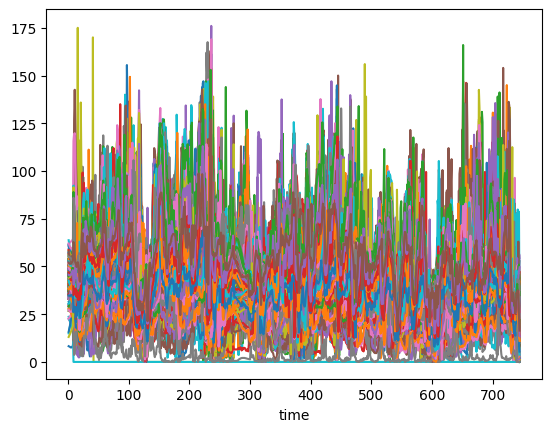

In [5]:
df.plot()
plt.legend().remove()

# 2.1.2 Remove seasonality

See seasonality.ipynb


We remove the seasonality via Ridge regression and take the residuals as our new df for the rest of the exploration.

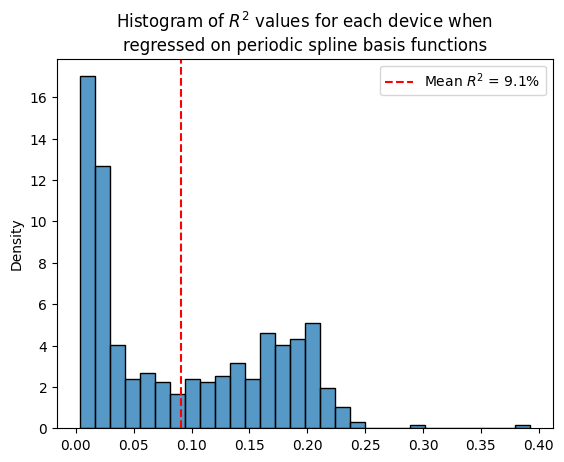

In [7]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 8

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

r2s = pd.Series(r2s, index = df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")])
sns.histplot(r2s, bins = 30, stat = "density")
plt.title("Histogram of $R^2$ values for each device when\nregressed on periodic spline basis functions")
plt.axvline(r2s.mean(), color = "red", linestyle = "--", label = f"Mean $R^2$ = {r2s.mean() * 100:.1f}%")
plt.legend()

residuals = pd.concat(residuals, axis = 1)
df = residuals

### 2.2 (P)ACF of mean station measurement

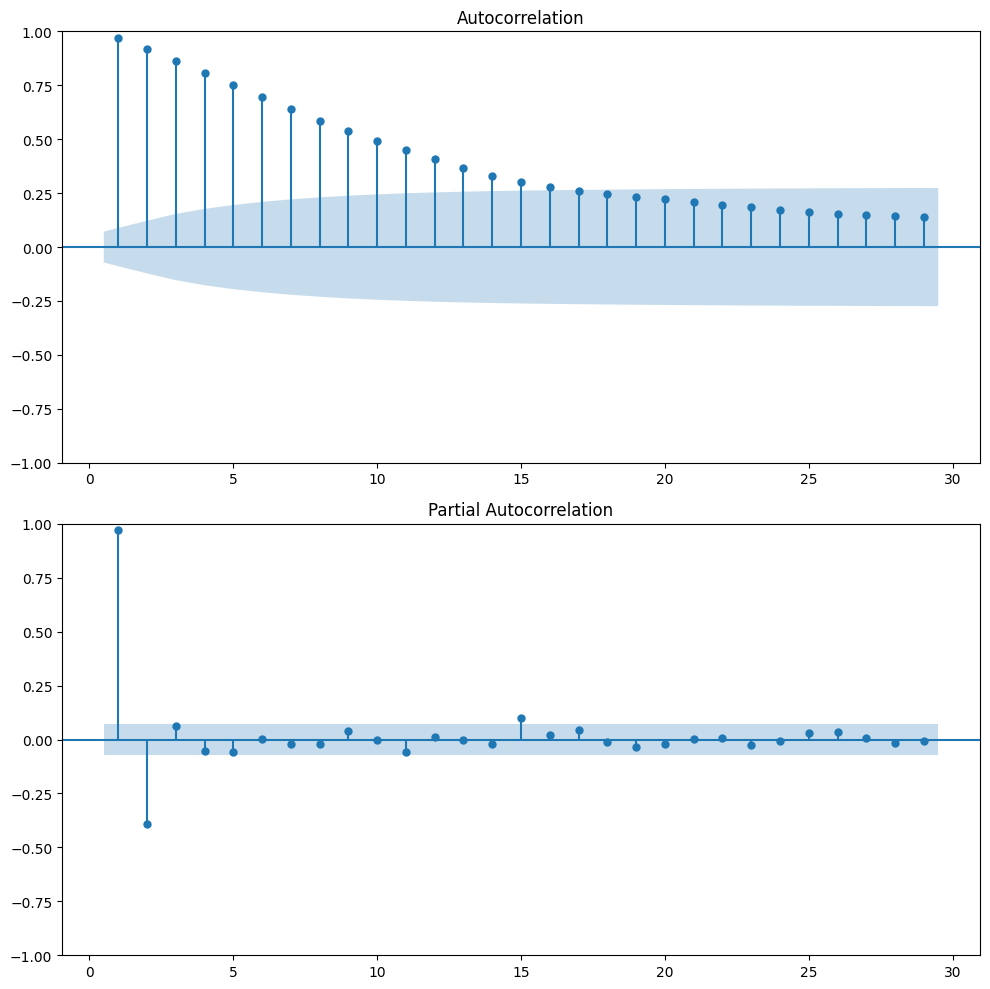

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

mu = df.mean(axis = 1)
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
plot_acf(mu, ax = axs[0], zero = False)
plot_pacf(mu, ax = axs[1], zero = False)
fig.tight_layout()


Obvious AR(2) model.

### 2.3. Stationarity check

<Axes: xlabel='time'>

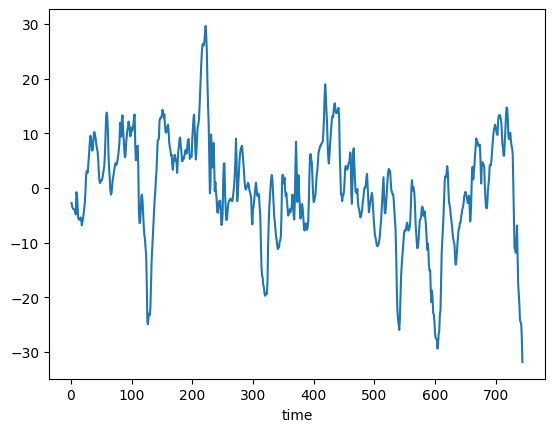

In [9]:
mu.plot()

In [10]:
from statsmodels.tsa.stattools import adfuller

# H0: The time series is non-stationary (no trend, no seasonality)
res = adfuller(mu, autolag = "AIC", regression = "c")
print(f"""
ADF Statistic: {res[0]}
p-value: {res[1]}
""")


ADF Statistic: -4.1215758949316434
p-value: 0.0008919769975840218



Reject H_0 => the (mean) series is stationary

### 2.4. Correlation matrix

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


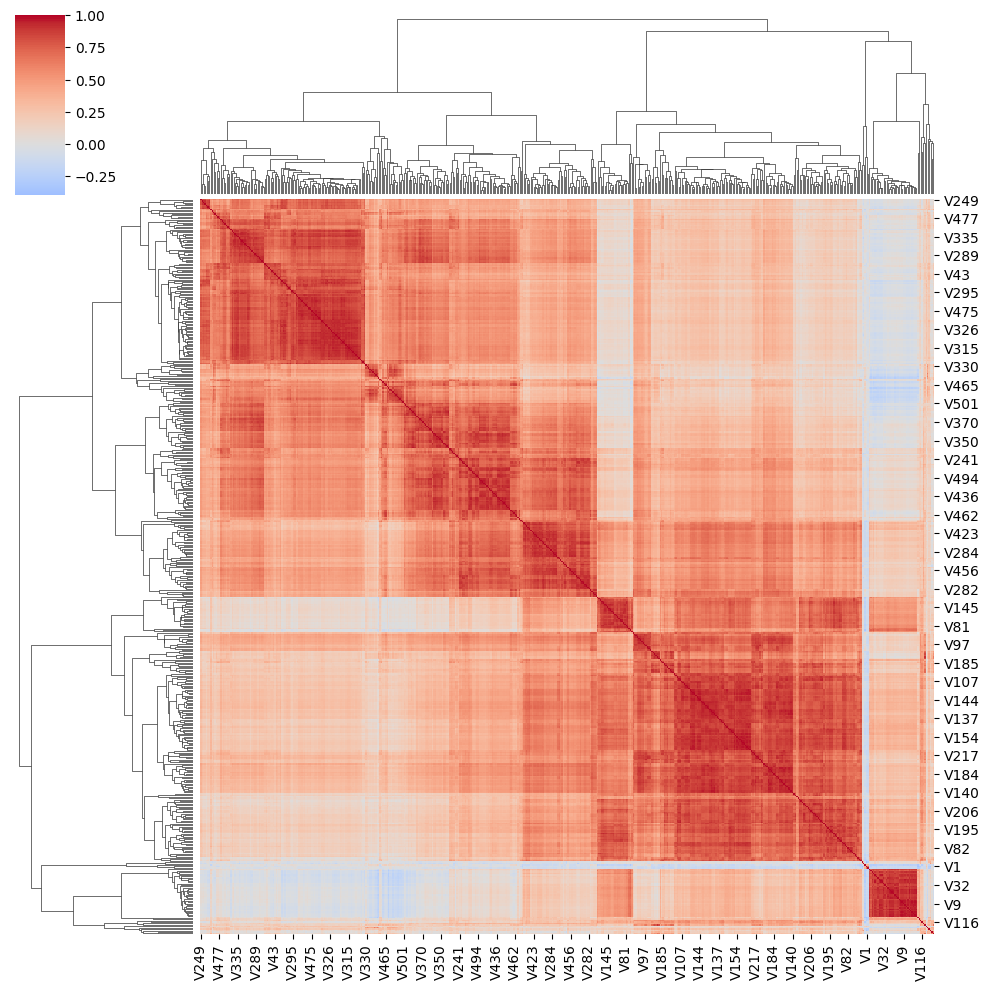

In [11]:
cg = sns.clustermap(df.corr(), cmap="coolwarm", center=0, figsize=(10, 10))
plt.show()


We observe that there is structure in the correlation matrix.

There is also a very small cluster of stations that are very highly correlated (top left).

Note that this does not take lagged measurements into account.

### 2.4.2. Cluster measurement stations using UMAP and KMeans

In [15]:
from umap import UMAP

umap = UMAP(n_components = 3, random_state = 0, n_neighbors = 30)
umap.fit(df.T)
umap.embedding_

df_clusters = pd.DataFrame(umap.embedding_, index = df.columns, columns = ["X", "Y", "Z"])
df_clusters

# now we construct 2 clusters based on the UMAP embedding
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(df_clusters)
df_clusters["Cluster"] = kmeans.labels_
df_clusters.index.name = "Column"
df_clusters.reset_index(inplace = True)
df_clusters

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Column,X,Y,Z,Cluster
0,V1,2.636546,3.622496,3.985392,0
1,V2,11.955896,0.317663,14.741549,0
2,V3,11.881007,0.659635,14.408116,0
3,V4,11.752536,0.785786,14.267178,0
4,V5,11.704905,0.498083,14.542971,0
...,...,...,...,...,...
511,V512,1.190224,4.046066,0.610775,0
512,V513,0.153256,2.776216,1.426734,0
513,V514,0.158283,2.436791,1.535746,0
514,V515,0.160256,2.765788,1.111881,0


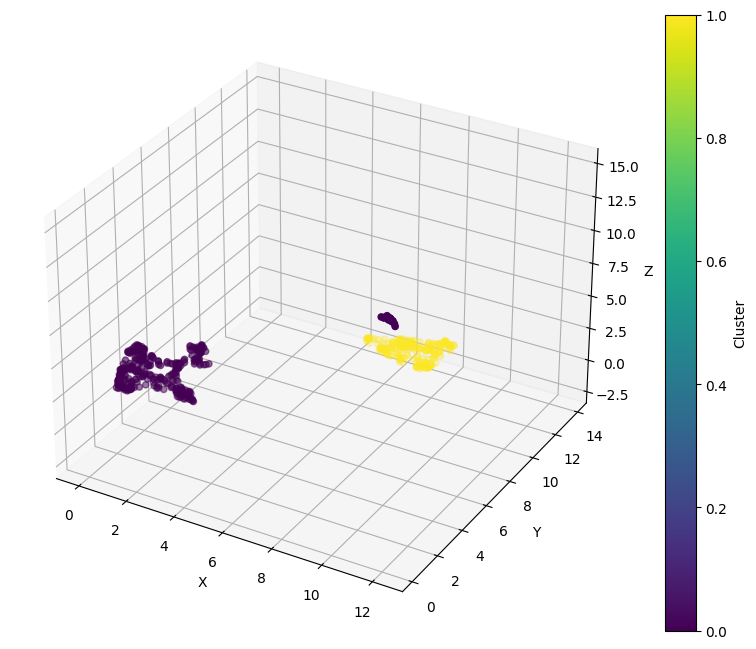

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Assuming df_clusters contains your data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot
scatter = ax.scatter(df_clusters['X'], df_clusters['Y'], df_clusters['Z'], c=df_clusters['Cluster'])

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Color bar
plt.colorbar(scatter, ax=ax, label='Cluster')

plt.show()

In [17]:
from umap import UMAP

umap = UMAP(n_components = 2, random_state = 0, n_neighbors = 30)
umap.fit(df.T)
umap.embedding_

df_clusters = pd.DataFrame(umap.embedding_, index = df.columns, columns = ["X", "Y"])
df_clusters

# now we construct 3 clusters based on the UMAP embedding
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(df_clusters)
df_clusters["Cluster"] = kmeans.labels_
df_clusters.index.name = "Column"
df_clusters.reset_index(inplace = True)
df_clusters

/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/maurits/miniconda3/envs/develop/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Column,X,Y,Cluster
0,V1,-0.140212,6.565242,1
1,V2,9.433427,2.894258,0
2,V3,9.088600,2.709025,0
3,V4,8.736662,3.036849,0
4,V5,9.302421,2.687287,0
...,...,...,...,...
511,V512,-3.982372,9.287551,1
512,V513,-4.236192,7.559492,1
513,V514,-4.393361,7.170869,1
514,V515,-4.417687,7.639973,1


<Axes: xlabel='X', ylabel='Y'>

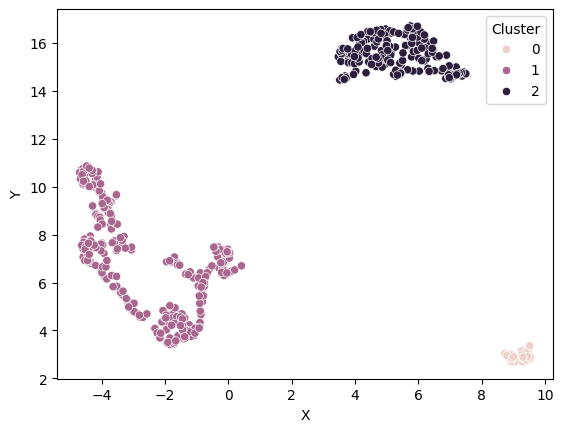

In [18]:
sns.scatterplot(data = df_clusters, x = "X", y = "Y", hue = "Cluster")

In [19]:
# OLD: hierarchical clustering. This sucked.

# import scipy.cluster.hierarchy as sch

# # Assuming 'cg' is your clustermap object
# # Use the linkage matrix from your clustermap
# linkage_matrix = cg.dendrogram_col.linkage

# # Number of clusters
# num_clusters = 4

# # Cutting the dendrogram
# cluster_labels = sch.fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# # Map the cluster labels to your DataFrame's columns
# df_clusters = pd.DataFrame({'Column': df.columns, 'Cluster': cluster_labels})

# df_clusters

In [20]:
df_clusters["Cluster"].value_counts()

Cluster
1    291
2    190
0     35
Name: count, dtype: int64

### 2.4.3 Visualise the clusters on a map

In [21]:
df_clusters = df_clusters.merge(locations, left_on = "Column", right_index = True)
df_clusters


,Column,X,Y,Cluster,latitude,longitude
0,V1,-0.140212,6.565242,1,1.306,103.920
1,V2,9.433427,2.894258,0,23.741,120.755
2,V3,9.088600,2.709025,0,25.073,121.536
3,V4,8.736662,3.036849,0,25.119,121.505
4,V5,9.302421,2.687287,0,25.056,121.552
...,...,...,...,...,...,...
511,V512,-3.982372,9.287551,1,23.366,120.366
512,V513,-4.236192,7.559492,1,22.954,120.244
513,V514,-4.393361,7.170869,1,22.945,120.230
514,V515,-4.417687,7.639973,1,23.004,120.230


In [22]:
import geopandas as gpd
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

/tmp/ipykernel_748813/171161396.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [23]:
display(locations.sort_values("latitude").head())
display(locations.sort_values("longitude").head())

,latitude,longitude
device,,
V1,1.306000,103.920
V35,1.322000,103.869
V118,3.046572,101.695
V155,14.647000,121.071
V157,21.004000,105.847


,latitude,longitude
device,,
V118,3.046572,101.695
V35,1.322000,103.869
V1,1.306000,103.920
V157,21.004000,105.847
V46,24.461000,118.452


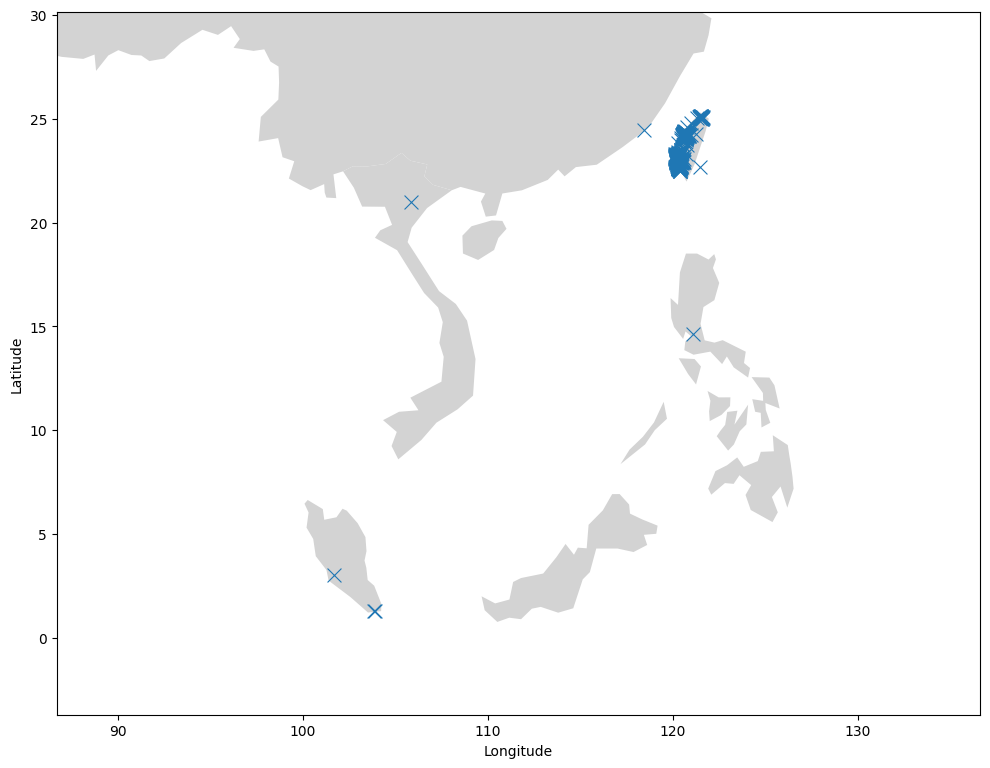

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))
y = countries[countries.apply(lambda row: row.geometry.contains(gpd.points_from_xy(df_clusters["longitude"], df_clusters["latitude"])).any(), axis = 1)]
y.plot(color="lightgrey", ax = ax)
# marker is x, 
sns.scatterplot(data = df_clusters, x = "longitude", y = "latitude", s = 100, marker = "x", ax = ax)
# set xlim, ylim to the min and max of the lat and long
ax.set_xlim([locations["longitude"].min() - 15, locations["longitude"].max() + 15])
ax.set_ylim([locations["latitude"].min() - 5, locations["latitude"].max() + 5])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
fig.show()
fig.tight_layout()
fig.savefig("../out/243_worldmap.png", dpi = 300)

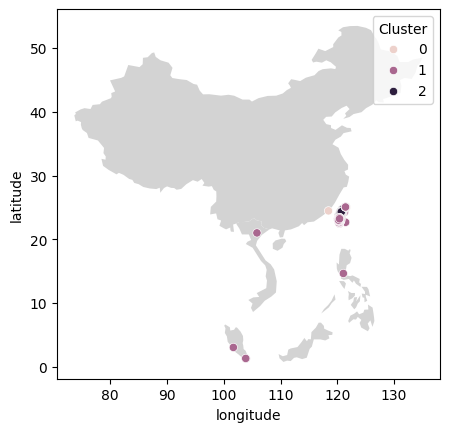

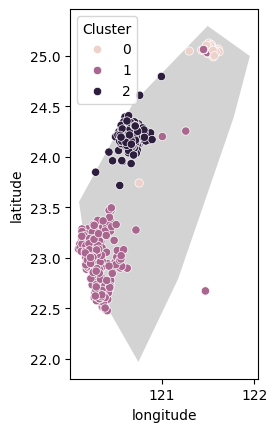

In [25]:
#countries[countries["name"] == "Taiwan"].plot(color="lightgrey")
#countries[countries["continent"] == "Asia"].plot(color="lightgrey")
y = countries[countries.apply(lambda row: row.geometry.contains(gpd.points_from_xy(df_clusters["longitude"], df_clusters["latitude"])).any(), axis = 1)]
y.plot(color="lightgrey")
sns.scatterplot(data = df_clusters, x = "longitude", y = "latitude", hue = "Cluster")
plt.show()

# now we only plot rows  where df[["latitude", "longitude"]] is contained within the Taiwan polygon
x = df_clusters[df_clusters["latitude"] > 18]
x = x[x["latitude"] < 26]
x = x[x["longitude"] > 119]
x = x[x["longitude"] < 123]

countries[countries["name"] == "Taiwan"].plot(color="lightgrey")
sns.scatterplot(data = x, x = "longitude", y = "latitude", hue = "Cluster")
plt.show()

### 2.5. Distribution of PM2.5

Text(0.5, 1.0, 'Histogram of Individual Observations')

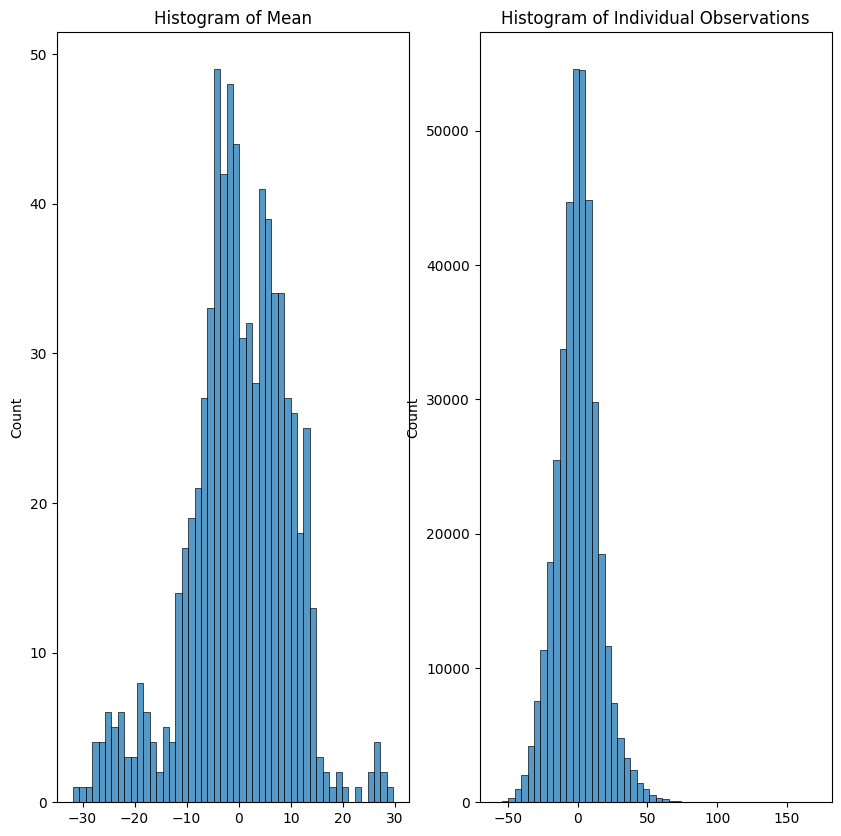

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (10, 10))
sns.histplot(mu, bins = 50, ax = axs[0])
axs[0].set_title("Histogram of Mean")

# indiv obs.
sns.histplot(df.values.flatten(), bins = 50, ax = axs[1])
axs[1].set_title("Histogram of Individual Observations")

We observe a short upward tail, and the distribution is clearly asymmetric due to the cutoff at 0.

We also notice the mean doesn't follow a normal distribution. This makes sense, as the CLT is not satisfied: our measurements are not independent.


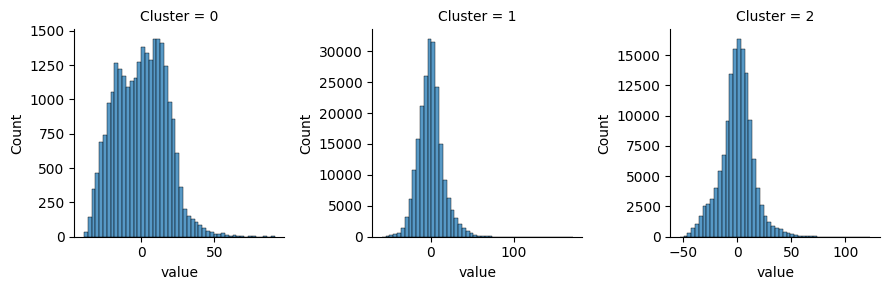

In [27]:
g = sns.FacetGrid(df.melt().merge(df_clusters[["Column", "Cluster"]]), col = "Cluster", col_wrap = 3, sharex = False, sharey = False)
g.map(sns.histplot, "value", bins = 50)

We also notice that the distribution for cluster 0 seems to behave differently from the other two clusters.

### 2.6. Correlation matrix per cluster

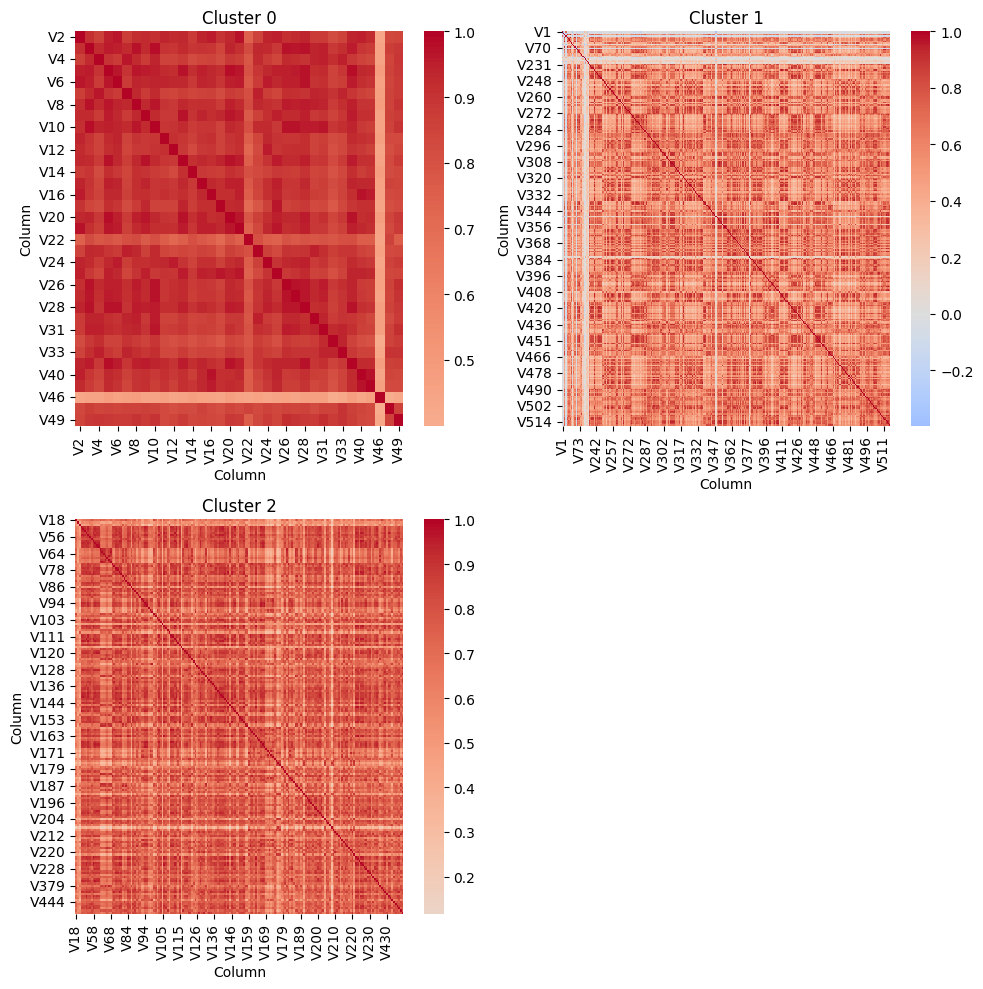

In [28]:
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
for i, ax in enumerate(axs.flatten()):
    # correlation matrix
    corr = df[df_clusters[df_clusters["Cluster"] == i]["Column"]].corr()
    if corr.shape[0] == 0:
        ax.axis("off")
        continue
    # plot the heatmap
    sns.heatmap(corr, cmap = "coolwarm", center = 0, ax = ax)
    # set title
    ax.set_title(f"Cluster {i}")
fig.tight_layout()


<Axes: xlabel='Column', ylabel='Column'>

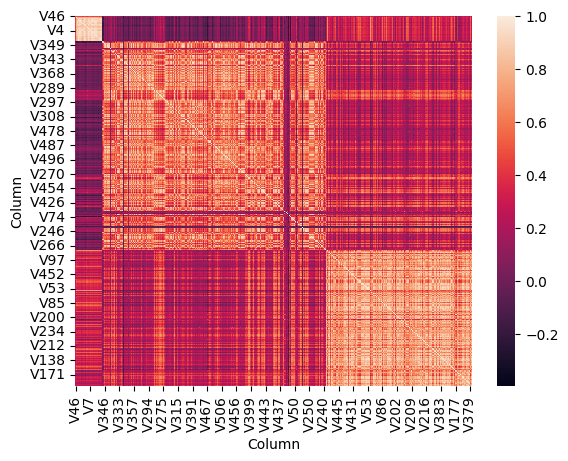

In [35]:
# fig, axs = plt.subplots(2, 2, figsize = (10, 10))
# for i, ax in enumerate(axs.flatten()):
#     # correlation matrix
#     corr = df[df_clusters[df_clusters["Cluster"] == i]["Column"]].corr()
#     if corr.shape[0] == 0:
#         ax.axis("off")
#         continue
#     # plot the heatmap
#     sns.heatmap(corr, cmap = "coolwarm", center = 0, ax = ax)
#     # set title
#     ax.set_title(f"Cluster {i}")
# fig.tight_layout()

reindexed_df = df.reindex(df_clusters.sort_values("Cluster")["Column"], axis = 1)
sns.heatmap(reindexed_df.corr())

### 2.7. Is the relationship between different sensors linear?

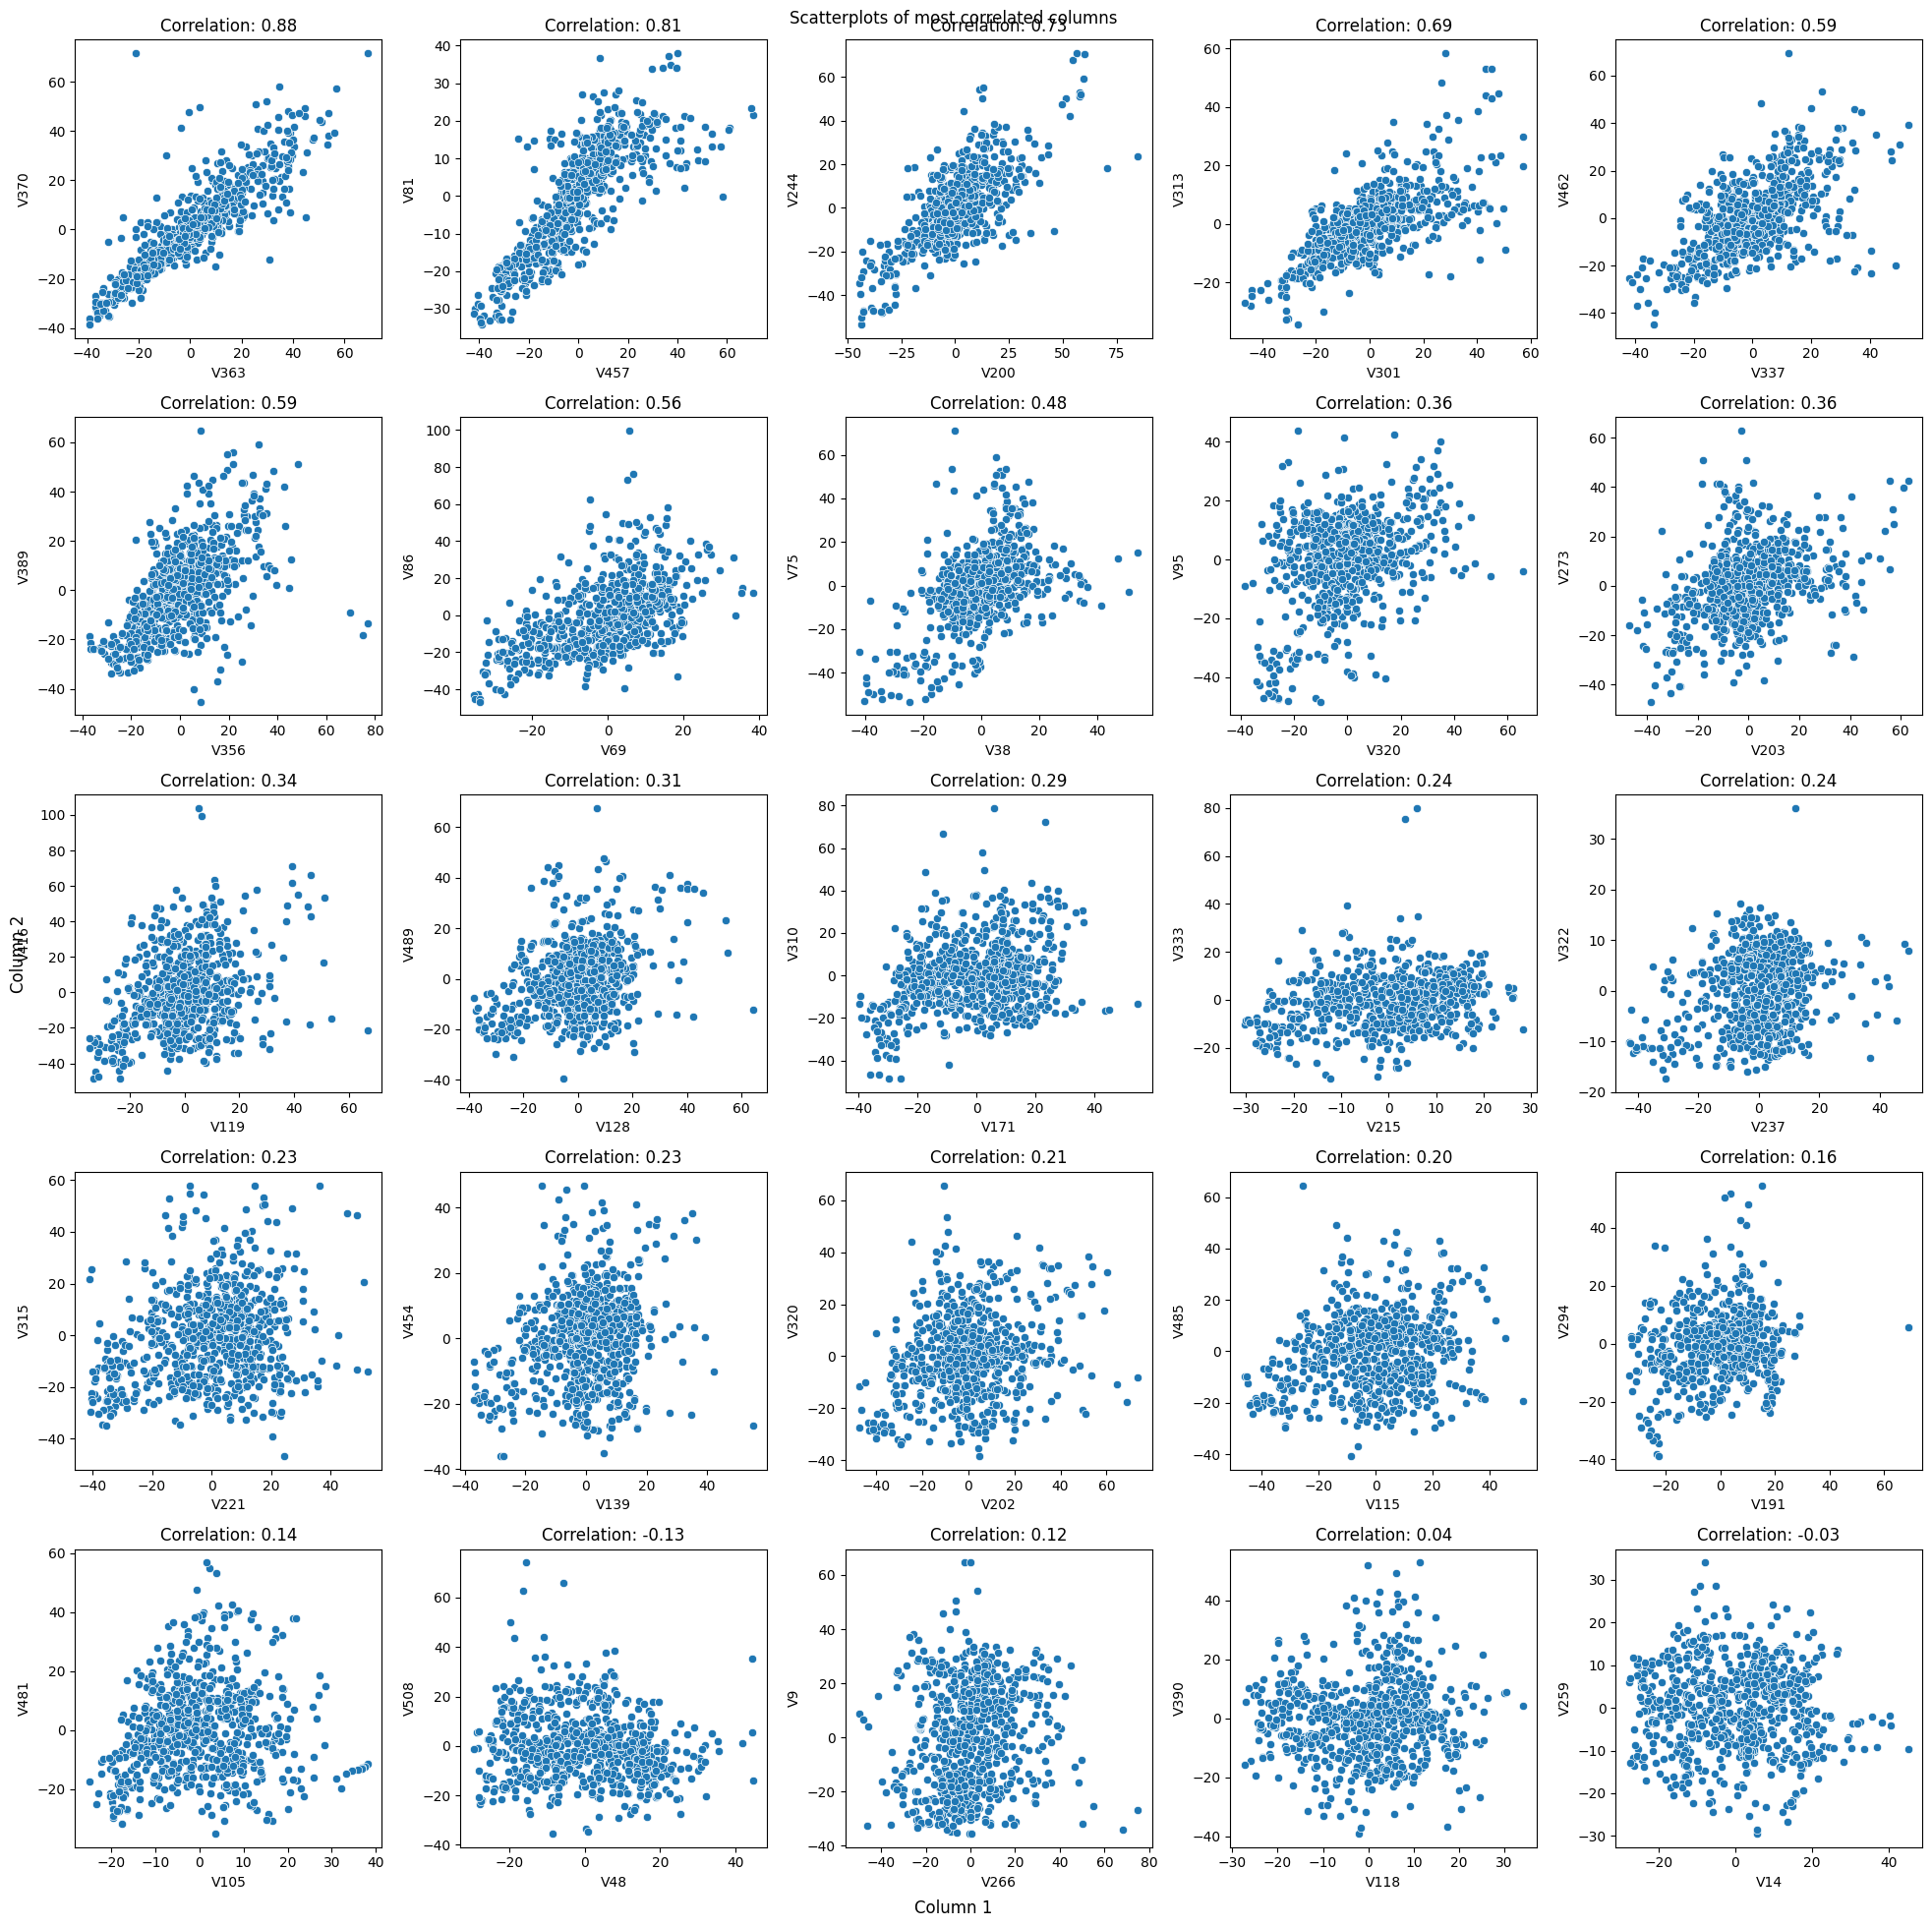

In [36]:
# we pick the most correlated columns
# and create scatterplots

NROW = 5
NCOL = 5
fig, axs = plt.subplots(NROW, NCOL, figsize = (20, 20))
corr_matrix = df.corr()
# set Column1 and Column2 as index
corr_matrix.index.name = "Column1"

# We start with a long-style df of correlations
corr_long = corr_matrix.unstack().reset_index()
corr_long.columns = ["Column1", "Column2", "Correlation"]

# We're going to sort by absolute correlation later
corr_long["AbsCorrelation"] = corr_long["Correlation"].abs()

# First, get rid of the diagonal
corr_long = corr_long[corr_long["Column1"] != corr_long["Column2"]]

# get rid of columns V{i}, V{j} where i < j (corr is symmetric)
corr_long = corr_long[corr_long["Column1"] < corr_long["Column2"]]

# take random NROW * NCOL
corr_long = corr_long.sample(NROW * NCOL).sort_values(by = "AbsCorrelation", ascending = False)

for i, (_, row) in enumerate(corr_long.iterrows()):
    sns.scatterplot(data = df, x = row["Column1"], y = row["Column2"], ax = axs[i // NCOL, i % NCOL])
    axs[i // NCOL, i % NCOL].set_title(f"Correlation: {row['Correlation']:.2f}")


fig.supxlabel("Column 1")
fig.supylabel("Column 2")

fig.suptitle("Scatterplots of most correlated columns")

fig.tight_layout()

We notice a lot of heteroskedasticity, but we have no reason to believe the relationship is nonlinear.

This means correlation is a good measure of similarity between sensors.

### 2.8. Autocorrelation behaviour per cluster

In [37]:
mu_per_cluster = df.reset_index().melt(var_name="Column", value_name="PM25", id_vars = "time").merge(df_clusters, how = "left").groupby(["Cluster", "time"])["PM25"].mean().sort_index()
mu_per_cluster

Cluster  time
0        1        6.696750
         2        6.889456
         3        7.080739
         4        7.277763
         5        7.445446
                   ...    
2        740    -36.715236
         741    -38.469172
         742    -38.336218
         743    -37.740072
         744    -37.205143
Name: PM25, Length: 2232, dtype: float64

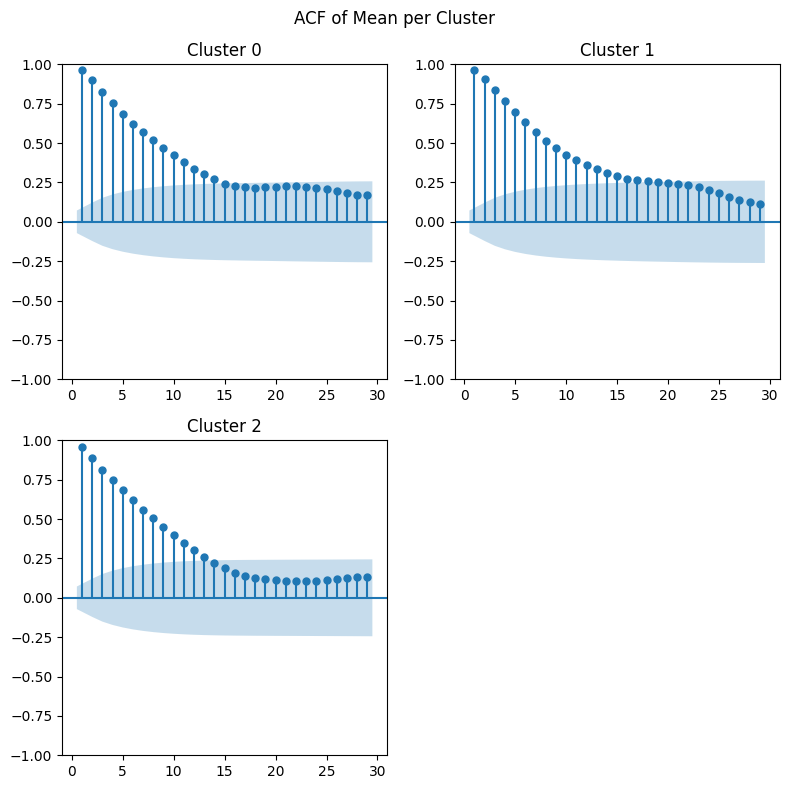

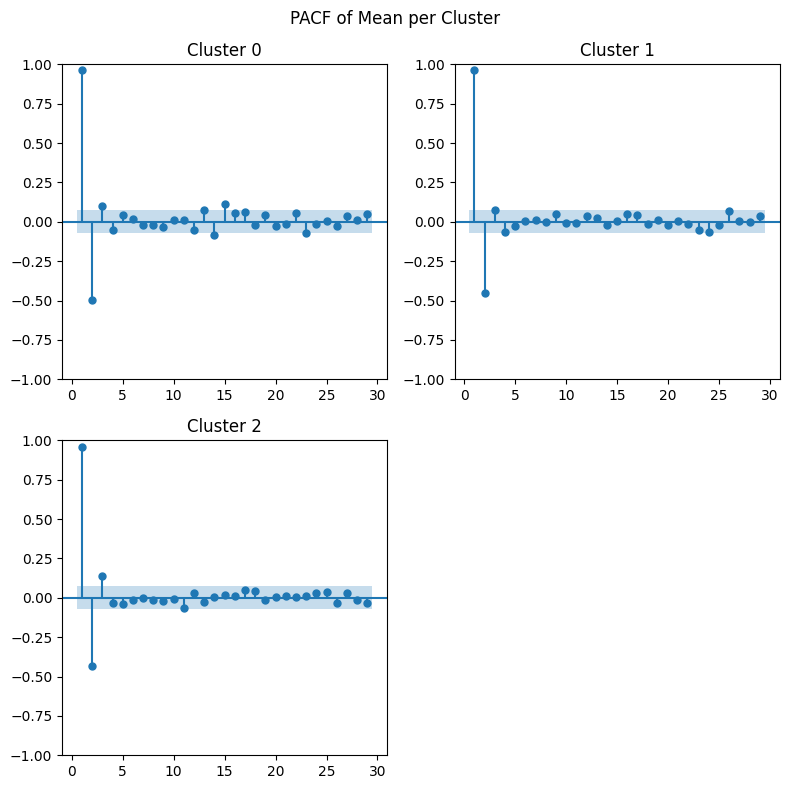

In [38]:
fig, axs = plt.subplots(2, 2, figsize = (8, 8))

for i in range(4):
    mu_for_cluster = mu_per_cluster[mu_per_cluster.index.get_level_values(0) == i]
    if mu_for_cluster.shape[0] == 0:
        axs[i // 2, i % 2].axis("off")
        continue

    plot_acf(mu_for_cluster, ax = axs[i // 2, i % 2], zero = False)
    axs[i // 2, i % 2].set_title(f"Cluster {i}")

fig.suptitle("ACF of Mean per Cluster")
fig.tight_layout()
fig.show()

fig, axs = plt.subplots(2, 2, figsize = (8, 8))

for i in range(4):
    mu_for_cluster = mu_per_cluster[mu_per_cluster.index.get_level_values(0) == i]
    if mu_for_cluster.shape[0] == 0:
        axs[i // 2, i % 2].axis("off")
        continue

    plot_pacf(mu_for_cluster, ax = axs[i // 2, i % 2], zero = False)
    axs[i // 2, i % 2].set_title(f"Cluster {i}")

fig.suptitle("PACF of Mean per Cluster")
fig.tight_layout()
fig.show()

We observe some sort of seasonality for cluster 1 (23 days?). It is interesting that this seasonality is not present in the other clusters.

Additionally, we notice that for cluster 0 and 2, the third lag seems to be significant. This was not the case when we took the entire

dataset as a whole.

Finally, we seem to have long memory in all three clusters. Fit a fractional ARIMA model?

### 2.9. Loess seasonal decomposition

This is old and doesn't make sense anymore given that we have removed seasonality.

<Axes: xlabel='Cluster,time'>

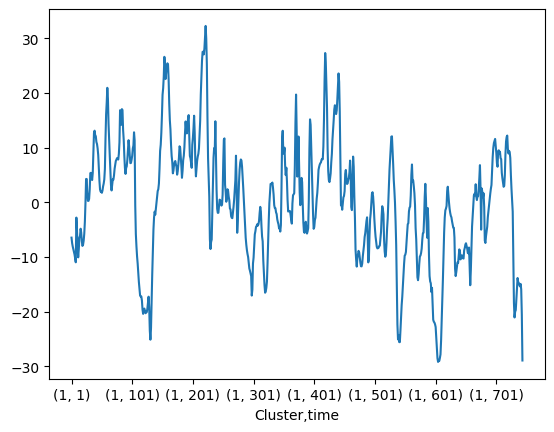

In [39]:
# Cluster 1 has potential periodicity
mu_for_cluster = mu_per_cluster[mu_per_cluster.index.get_level_values(0) == 1]

mu_for_cluster.plot()

/tmp/ipykernel_748813/2020019336.py:10: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(frequencies != 0, 1.0 / frequencies, np.inf)


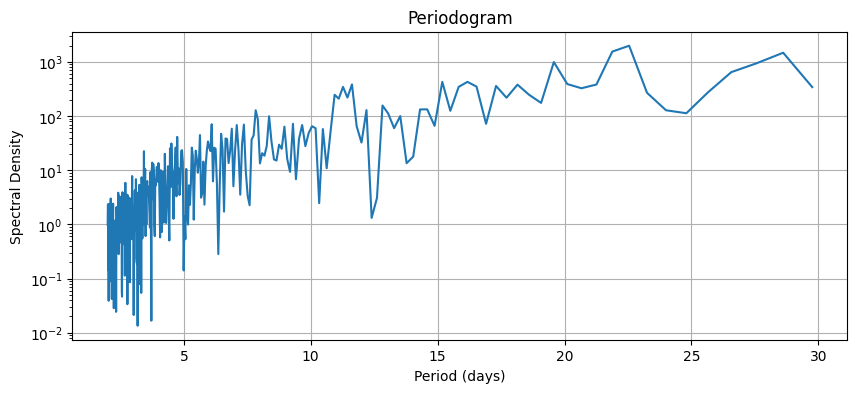

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Compute the periodogram
frequencies, spectrum = signal.periodogram(mu_for_cluster)

# Convert frequencies to periods (in days)
# Avoid division by zero
periods = np.where(frequencies != 0, 1.0 / frequencies, np.inf)

# Filter out periods that are outside the range of interest (5 to 60 days)
mask = (periods >= 2) & (periods <= 30)
filtered_periods = periods[mask]
filtered_spectrum = spectrum[mask]

# Plot the periodogram with periods on the x-axis
plt.figure(figsize=(10, 4))
plt.semilogy(filtered_periods, filtered_spectrum)
plt.title('Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Spectral Density')
plt.grid(True)
plt.show()


Peak at 24 days, which is a bit weird.

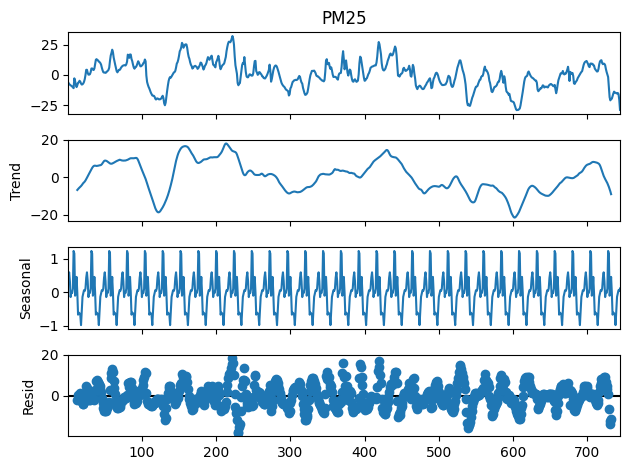

In [41]:
# loess seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# fig, axs = plt.subplots(2, 2, figsize = (8, 8))

mu_for_cluster = mu_per_cluster[mu_per_cluster.index.get_level_values(0) == 1]
mu_for_cluster = mu_for_cluster.reset_index().set_index("time")
mu_for_cluster
# decompose PM25
decomp = seasonal_decompose(mu_for_cluster["PM25"], model = "additive", period = 24)
decomp.plot()
plt.show()

Loess decomposition doesn't seem to work well, sawtooth pattern in residuals.

Conclusion: no seasonality in the data, even in cluster 1.